#### Adding RAG to Langgraph Workflow

In [1]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings
embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")

d:\learning\learn_langgraph_ss\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")
GROQ_API_KEY = os.getenv("GROQ_API_KEY")
LANGCHAIN_API_KEY = os.getenv("LANGCHAIN_API_KEY")
LANGCHAIN_PROJECT = os.getenv("LANGCHAIN_PROJECT")
LANGSMITH_TRACING="true"
LANGSMITH_ENDPOINT="https://api.smith.langchain.com"
LANGSMITH_API_KEY= os.getenv("LANGSMITH_API_KEY")

In [4]:
from langchain_groq import ChatGroq
llm = ChatGroq(model_name="Llama3-8b-8192")

In [5]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_community.document_loaders import TextLoader, DirectoryLoader
from langchain_community.vectorstores import Chroma
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [6]:
loader = DirectoryLoader("data",glob="./*.txt",loader_cls=TextLoader)
docs = loader.load()
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 100,
    chunk_overlap = 50
)
new_docs = text_splitter.split_documents(documents=docs)
doc_strings = [doc.page_content for doc in new_docs]

db = Chroma.from_documents(new_docs, embeddings)
retriever = db.as_retriever(search_kwargs={"k":3})

query = "What is meta llama3?"
docs = retriever.get_relevant_documents(query)
print(docs[0].metadata)
print(docs[0].page_content)

for doc in docs:
    print(doc)

C:\Users\Vikas Chauhan\AppData\Local\Temp\ipykernel_17604\1703995170.py:14: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  docs = retriever.get_relevant_documents(query)


{'source': 'data\\llama3.txt'}
Alongside the release of Llama 3, Meta added virtual assistant features to Facebook and WhatsApp in
page_content='Alongside the release of Llama 3, Meta added virtual assistant features to Facebook and WhatsApp in' metadata={'source': 'data\\llama3.txt'}
page_content='by Meta AI starting in February 2023.[2][3] The latest version is Llama 3 released in April' metadata={'source': 'data\\llama3.txt'}
page_content='Llama 2, Meta AI started releasing instruction fine-tuned versions alongside foundation models.[7]' metadata={'source': 'data\\llama3.txt'}


In [7]:
def function_1(AgentState):
    message = AgentState["messages"]
    question = message[-1]
    complete_prompt = "Your task is to provide only the brief answer based on the user query. \
        Don't include too much reasoning. Following is the user query: " + question
    response = llm.invoke(complete_prompt)
    AgentState['messages'].append(response.content)
    return AgentState

In [8]:
def function_2(AgentState):
    messages = AgentState['messages']
    question = messages[0]
    
    template = """Answer the question based only on the following context:
    {context}
    
    Question: {question}
    """
    prompt = ChatPromptTemplate.from_template(template)
    
    retrieval_chain = (
        {"context": retriever, "question": RunnablePassthrough()}
        | prompt
        | llm
        | StrOutputParser()
        )
    result = retrieval_chain.invoke(question)
    return result

In [9]:
from langgraph.graph import Graph
workflow4 = Graph()

In [10]:
workflow4.add_node("LLM", function_1)
workflow4.add_node("RAGtool", function_2)
workflow4.add_edge("LLM", "RAGtool")
workflow4.set_entry_point("LLM")
workflow4.set_finish_point("RAGtool")
app4 = workflow4.compile()

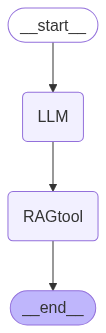

In [11]:
from IPython.display import Image, display

try:
    display(Image(app4.get_graph().draw_mermaid_png()))
except Exception as e:
    print(e)

In [12]:
app4.invoke({"messages":["Tell me about llama3 model"]})

'According to the provided context, here\'s what can be said about the Llama3 model:\n\n* The 8B parameter version of Llama 3 is considered "surprisingly capable" given its size.\n* Llama models, including Llama 3, have been compared favorably against other large language models.\n* The 8B parameter version of Llama 3 has been reported to perform well in most benchmarks, alongside Claude.'

In [13]:
input = {"messages":["Tell me about llama3 model"]}
for output in app4.stream(input):
    for key, value in output.items():
        print(f"Output from node '{key}':")
        print("----------------------------")
        print(value)
        print("\n----------------------------\n")

Output from node 'LLM':
----------------------------
{'messages': ['Tell me about llama3 model', "The Llama-3 model is a large-scale language model developed by Facebook AI and Carnegie Mellon University. It's a multimodal transformer model that can process text, images, and audio, achieving state-of-the-art results in several natural language processing tasks."]}

----------------------------

Output from node 'RAGtool':
----------------------------
According to the provided context, here's what can be inferred about the Llama3 model:

* The 8B parameter version of Llama 3 is considered "surprisingly capable" given its size.
* Llama models, including Llama 3, have been compared favorably against other large language models.
* In most benchmarks, Llama 3 (specifically the 8B parameter version) outperformed Claude and other models, according to Meta AI.

----------------------------



In [14]:
input = {"messages":["What is the capital of India?"]}
for output in app4.stream(input):
    for key, value in output.items():
        print(f"Output from node '{key}':")
        print("----------------------------")
        print(value)
        print("\n----------------------------\n")

Output from node 'LLM':
----------------------------
{'messages': ['What is the capital of India?', 'New Delhi']}

----------------------------

Output from node 'RAGtool':
----------------------------
I'm not seeing any information about the capital of India in the provided context. The context only appears to be about "Llama 3" and mentions of other models and websites. I'd be happy to help with any other question that can be answered based on this context!

----------------------------



#### New Workflow

In [28]:
loader2 = DirectoryLoader("data2",glob="./*.txt",loader_cls=TextLoader)
docs2 = loader2.load()
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 100,
    chunk_overlap = 50
)
new_docs2 = text_splitter.split_documents(documents=docs2)
doc_strings2 = [doc.page_content for doc in new_docs2]

db2 = Chroma.from_documents(new_docs2, embeddings)
retriever2 = db2.as_retriever(search_kwargs={"k":3})

query = "India's Industrial Growth"
docs2 = retriever2.get_relevant_documents(query)
print(docs2[0].metadata)
print(docs2[0].page_content)

for doc in docs2:
    print(doc)

{'source': 'data2\\indian_economy.txt'}
India’s industrial growth has outpaced expectations, raising hopes that the economy will avoid a
page_content='India’s industrial growth has outpaced expectations, raising hopes that the economy will avoid a' metadata={'source': 'data2\\indian_economy.txt'}
page_content='India’s industrial growth has outpaced expectations, raising hopes that the economy will avoid a' metadata={'source': 'data2\\indian_economy.txt'}
page_content='Industrial Revival and Economic Optimism for India' metadata={'source': 'data2\\indian_economy.txt'}


In [29]:
from typing import TypedDict, Annotated, Sequence
import operator
from langchain_core.messages import BaseMessage
from langchain.prompts import PromptTemplate

In [30]:
class AgentState(TypedDict):
    # The 'messages' field should be a sequence of strings, and we annote it with 'operator.add'
    # This implies we might want to "add" new messages to the sequence later
    messages: Annotated[Sequence[BaseMessage], operator.add]

In [31]:
from pydantic import BaseModel, Field
class TopicSelectionParser(BaseModel):
    Topic: str = Field(description='Selected Topic')
    Reasoning: str = Field(description='Reasoning behind topic selection')

In [32]:
from langchain.output_parsers import PydanticOutputParser
parser = PydanticOutputParser(pydantic_object=TopicSelectionParser)

In [33]:
def function_1(state):
    message = state['messages']
    question = message[-1]
    print(question)
    
    template = """
    Your task is to classify the given user query into one of the following categories: [India, Not Related].
    Only respond with the category name and nothing else.
    
    user query: {question}
    {format_instructions}
    """
    
    prompt = PromptTemplate(template=template,
                            input_variables=[question],
                            partial_variables={
                                "format_instructions": parser.get_format_instructions()
                            })
    
    chain = prompt | llm | parser
    
    response = chain.invoke({"question": question, "format_instructions": parser.get_format_instructions()})
    print(response)
    
    return {"messages": [response.Topic]}

In [34]:
def router(state):
    print("-> Router ->")
    
    messages = state['messages']
    last_message = messages[-1]
    print(last_message)
    if 'India' in last_message:
        return 'RAG Call'
    else:
        return 'LLM Call'

In [35]:
def function_2(state):
    print("-> Calling RAG ->")
    messages = state['messages']
    question = messages[0]
    print(question)
    
    template = """Answer the question based only on the following context:
    {context}
    
    Question: {question}
    """
    prompt = ChatPromptTemplate.from_template(template)
    print(prompt)
    
    retrieval_chain = (
        {"context": retriever2, "question":RunnablePassthrough()}
        | prompt
        | llm
        | StrOutputParser()
    )
    result = retrieval_chain.invoke(question)
    return {"messages": [result]}

In [36]:
def function_3(state):
    print("-> Calling LLM ->")
    messages = state['messages']
    question = messages[0]
    
    complete_query = "Answer the follow question with your knowledge of the real world, following is the user question: " + question
    response = llm.invoke(complete_query)
    return {"messages":[response.content]}

In [37]:
from langgraph.graph import StateGraph, END

workflow5 = StateGraph(AgentState)

workflow5.add_node("agent", function_1)
workflow5.add_node("RAG", function_2)
workflow5.add_node("LLM", function_3)
workflow5.set_entry_point("agent")
workflow5.add_conditional_edges(
    "agent",
    router,
    {
        "RAG Call": "RAG",
        "LLM Call": "LLM",
    }
)
workflow5.add_edge("RAG",END)
workflow5.add_edge("LLM",END)
app5 = workflow5.compile()

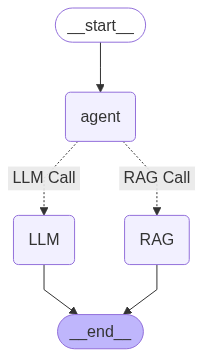

In [38]:
from IPython.display import Image, display

try:
    display(Image(app5.get_graph().draw_mermaid_png()))
except Exception as e:
    print(e)

In [39]:
app5.invoke({"messages":["Tell me about India's Industrial Growth"]})

Tell me about India's Industrial Growth
Topic='India' Reasoning="User query is about India's Industrial Growth"
-> Router ->
India
-> Calling RAG ->
Tell me about India's Industrial Growth
input_variables=['context', 'question'] input_types={} partial_variables={} messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template='Answer the question based only on the following context:\n    {context}\n\n    Question: {question}\n    '), additional_kwargs={})]


{'messages': ["Tell me about India's Industrial Growth",
  'India',
  "According to the provided context, India's industrial growth has outpaced expectations."]}

In [40]:
input = {"messages":["Tell me about India's Industrial Growth"]}
for output in app5.stream(input):
    for key, value in output.items():
        print(f"Output from node '{key}':")
        print("----------------------------")
        print(value)
        print("\n----------------------------\n")

Tell me about India's Industrial Growth
Topic='India' Reasoning="Query contains keywords related to India's Industrial Growth"
-> Router ->
India
Output from node 'agent':
----------------------------
{'messages': ['India']}

----------------------------

-> Calling RAG ->
Tell me about India's Industrial Growth
input_variables=['context', 'question'] input_types={} partial_variables={} messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template='Answer the question based only on the following context:\n    {context}\n\n    Question: {question}\n    '), additional_kwargs={})]
Output from node 'RAG':
----------------------------
{'messages': ["According to the provided context, India's industrial growth has outpaced expectations, raising hopes that the economy will avoid a [something]."]}

----------------------------



In [44]:
input = {"messages":["Tell me about President of USA"]}
for output in app5.stream(input):
    for key, value in output.items():
        print(f"Output from node '{key}':")
        print("----------------------------")
        print(value)
        print("\n----------------------------\n")

Tell me about President of USA
Topic='Not Related' Reasoning='The query is about the President of USA which is not related to India'
-> Router ->
Not Related
Output from node 'agent':
----------------------------
{'messages': ['Not Related']}

----------------------------

-> Calling LLM ->
Output from node 'LLM':
----------------------------
{'messages': ["A great topic!\n\nAs of now, the President of the United States is Joe Biden. He is the 46th President of the United States, serving since January 20, 2021. Prior to becoming President, Biden served as the 47th Vice President of the United States from 2009 to 2017, under the administration of President Barack Obama.\n\nBefore entering politics, Biden earned a Bachelor's degree in English from the University of Delaware and a Juris Doctor (J.D.) from Syracuse University College of Law. He began his political career in the Delaware State Senate, serving from 1973 to 1979, and then represented Delaware in the United States Senate from 